<a href="https://colab.research.google.com/github/Cind0928/SIM_YAC_URRUNAGA_UPSE2023/blob/main/solucion_explicita_implicita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Metodos explicito e implicito
# Importamos las bibliotecas
import numpy as np #vector
import math

In [24]:
#Datos del reservorio y petrofisicos
L=10000 # longitud de reservorio
dx=250 # separación de nodos
Tiempo= 100000 # numero de días (division a dt se tiene numero de iteraciones)
DT=1 # intervalo de tiempo en dias
K=50 #Permeabilidad MD
por=0.2 #Porosidad u
vis=1 # viscocidad (centipoise)
Beta=1 # factor volumetrico (se asume constante)
CompTotal=1**-6 #compresibilidad total psi-1
Area=200000 #ft**2 (area del reseervorio)

In [25]:
Alpha=K/(vis*por*CompTotal) # dada la forma de difusividad d2p/dx2=(1/alpha)dp/dt, alpha ya no es uno
Alpha
Eta=Alpha*DT/(dx**2) # para hallar estabilidad varia dx (100 a 2500), DT (100 a 1); oj comp 1**-6  ; si alpha es uno simplemente dx es doble DT
Eta

0.004

In [26]:
#Esquema Explícito
#Pi(**)n+1=Pi(**)n + alphaDT/dx**2 [Pi-1(**)n - 2Pi(**)n + Pi+1(**)n], considerar Eta=alphaDT/dx2, Estable: Eta menor 0.5
def Presdt(P0,P1,P2,Eta): # (funcion esquema eplicito usando Eta en lugar DT y dx)
  Pdt=P1+Eta*(P0-2*P1+P2)
  return(Pdt)

Pexplicita=np.zeros((Tiempo//DT,L//dx)) # matriz que va a guardar todos los resultados. Filas N: Iteraciones, Columnas m: numero de Nodos

In [27]:
# Condiciones esquema explicito inicial

Pyac=1000 # presion de yacimiento psi # se da valores al vector de presiones inciales
Piz=500 # presion frontera izquierda psi
Pder=0 # presion frontera derecha psi (todo flow)

Pin=np.ones(L//dx) #vector de presiones iniciales (es cantidad de nodos y los datos están con unos)
Pres=np.zeros(L//dx) #vector de resultados
Pres2=np.zeros(L//dx) #vector de resultados para la solucion implicita
Pin=Pin*Pyac #valores del vector incial como presion de yacimiento (tiempo=0)
#Atribuir valores al vector d condiciones iniciales
Pin[0]=Piz #primera celda (0) del vector Pin será Pizquierda (frontera izquierda)
Pin[len(Pin)-1]=Pder #ultima celda del vector menos 1 es frontera derecha (en python)

Pin

array([ 500., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000.,    0.])

In [28]:
Pin[len(Pin)-1]

0.0

In [29]:
t=DT
Pexplicita[0]=Pin           # en la matriz Pexplicita, la presion de la primera fila será la presión incial
while t<Tiempo:                  # Se empieza calculos con ciclo en base al tiempo, llenarán la fila 2,3,... (se tendran resultados con una iteracion menos)
  for i in range(0,len(Pin)-1):  # creacion del ciclo de espacio (columnas: (0)es primer valor, (Pin)-1 es ultimo valor)
    if i==0:                    # i==0 representa la posición del nodo en todos los puntos de la frontera izquierda
      Pres[i]=Pin[0]            #Pin[i]=Piz definido en condiciones iniciales, (con vector de resultados Pres se llenan  todos los valores de la columna en i =0, frontera izq)
    elif i==len(Pin)-1:         # posición de i en frontera derecha
      Pres[i]=Pin[len(Pin)-1]   #Pin[len(Pin)-1]=Pder definido en condiciones iniciales, (así se llenan todos los valores de la columna final i = num nodos menos 1, frontera der)
    else:                       # en todos los demás puntos  se llamará a la funcion denominada Presdt para las presiones futuras
      Pres[i]=Presdt(Pin[i-1],Pin[i],Pin[i+1],Eta)  # triangulo de posicion i, i-1, i+1, con relacion a valores del vector anterior que sería la presion de i-1, presion de i, presion de i+1; factor Eta (dif a 1); con i da cambio nodo por nodo
  Pexplicita[t//DT]=Pres         # Pres vector pone valores en la siguiente fila de la matriz (sale del condicional)
  t=t+DT                        # siguiente ciclo
  Pin=Pres                      # vector inicial recopila al vector de resultads anterior, y llena los triangulos sucesivamente

In [30]:
Pexplicita                    # Resultados de la matriz seteada

array([[ 500.        , 1000.        , 1000.        , ..., 1000.        ,
        1000.        ,    0.        ],
       [ 500.        ,  998.        , 1000.        , ..., 1000.        ,
         996.        ,    0.        ],
       [ 500.        ,  996.016     ,  999.984064  , ...,  999.984     ,
         992.031936  ,    0.        ],
       ...,
       [ 500.        ,  492.8590487 ,  485.68113097, ...,   36.96108851,
          18.49889128,    0.        ],
       [ 500.        ,  492.85890083,  485.6808362 , ...,   36.96079355,
          18.49874332,    0.        ],
       [ 500.        ,  492.85875297,  485.68054143, ...,   36.96049861,
          18.49859537,    0.        ]])

In [31]:
# Esquema Implícito

In [32]:
# Solucion explicita con sistema de ecuaciones 1:41 del video
# Matriz tridiagonal - Eta, 1+2Eta, -Eta
# Matriz cuadrada NxN,  Tamaño depende de numero de triangulos, cada uno es ecuacion, num incogn es num ecuaciones, lineal
# num ecuaciones N = #nodos-2
# indices i,J de matriz, diagonal si i=J valor numérico del término es 1+2Eta
# índice J-1 ó J+1 corresponden a valor numérico -Eta

In [33]:
Pimplicita= np.zeros((Tiempo//DT,L//dx))    #  matriz implicita de resultados (diferente a matriz donde se resolvera las presiones futura o Matriz de resolucion)
Pin=np.ones(L//dx) #vector de presiones iniciales (es cantidad de nodos)
Pres=np.zeros(L//dx) #vector de resultados de ceros
Pin=Pin*Pyac #valores del vector incial como presion de yacimiento (tiempo=0)
Pin[0]=Piz # #Atribuir valores al vector d condiciones iniciales, primera celda (0) del vector Pin será Pizquierda (frontera izquierda)
Pin[len(Pin)-1]=Pder
N=L//dx   # Numero de nodos= long yac / dx
Matriz_resolucion=np.zeros([N-2,N-2]) # matriz que resolvera el sistema de ecuaciones, dimensiones N-2, N-2, cuadrada, tiene 2 nodos menos q la matriz de resultados Pimplicita

In [34]:
for i in range(N-2):              # CICLO ESPACIO ESQUEMA IMPLÍCITO.-para Llenar valores de matriz de resultados Pimplicita se apoya de la matrz de resolucion. Pyton reconoce con indice 0 a frontera izq y der (primera y ult columna), en la matriz Pimplicita
  Matriz_resolucion[i,i]=1+2*Eta  # Matriz de resolucion sst ecuaciones.-seteos de valores de diagonal versus asignacion de indices [i,i], filas igual a columnas. En Pyton, primera fila matriz resolucion tiene indice cero
  if i>0:                          # Matriz de resolucion.-Pyton segunda fila, lado izquierdo de la diagonal i=1 (por debajo); el valor nuerico es -Eta
    Matriz_resolucion[i,i-1]=-Eta
  if i<(N-3):                     # Matriz de resolucion N-2 x N-2.- por encima de la diagonal  en N-3 (Pyton) el valor nuerico es -Eta (ver 2h15 min video)
    Matriz_resolucion[i,i+1]=-Eta # Matriz q se usará en todos los tiempos

In [35]:
# Resolucion de sistema ecuaciones matriciales en Pyton A.Pexp(n+1)= Poexp(n) ver video 2h30


In [36]:
Pcal=np.zeros([N-2])      # vector vacio de tamaño N-2 de Presiones calculadas que se obtendrán sin incluir fronteras ni condiciones iniciales.
Pcal=np.linalg.solve(Matriz_resolucion,Pin[1:-1]) # Pin[1:-1] Vector inicial sin los resultados de la frontera (desde el valor 1 al valor final -1)

In [37]:
Pres2.shape #comprobacion de vector de resultados de presion

(40,)

In [38]:
Pres=np.concatenate(([Piz],Pcal,[Pder]))  # ooojoooo al poner np.concatenate= , sobrescribe funcion y da error; se probo con vector Pres2 pero despues de reiniciar Pyton no fue necesario Pres2

In [39]:
#Condiciones de frontera (concatenate toma varios valores de matriz calculada y junta los valores de frontera)
Pres=np.concatenate(([Piz],Pcal,[Pder]))
Pres

array([ 500.        ,  996.03168354,  999.98425246,  999.99993751,
        999.99999975, 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        ,  999.99999975,
        999.99993751,  999.98425246,  996.03168354,    0.        ])

In [40]:
#Pasos del ciclo tiempo del problema implícito
Pimplicita[0]=Pin       # primiera fila de pimplicita es vector de presiones iniciales
t=DT                    # primer tiempo es DT
while t<Tiempo:          #ciclo en tiempo
  Pcal=np.linalg.solve(Matriz_resolucion,Pin[1:-1])  # Presion calculada,secuencia de numeros de matriz solucion y pinicial
                                                     # PRIMERA PRESION q calcularé es igual a la resolución con alg lineal de la matriz tomando el vector de presiones iniciales desde el índice 1 al -1 (valores del medio sin las fronteras), resolucion de sistema de ecuaciones o triangulos de la fila t=DT (resultados seran guardados en el vector Pcal)
                                                     # Matriz eta * matriz Pn+1 (incognitas) = Pn (pyton resuelve las incogntas del sistema matricial lineal)
  Pres=np.concatenate(([Piz],Pcal,[Pder]))           # a Pcal se pone los valores de frontera por medio de concatenate en vector Presion de resultados
  Pimplicita[t//DT]=Pres                             # esos tres valores Piz, Pcal, Pder se pondran en la matriz Pimplicita q se guardara en el vector Pres (resultados)
  Pin=Pres                                           # para calcular Pcal usamos Pin vect presiones iniciales q es el anterior; asi se consigue la secuencia e la fila siguiente t+DT y luego en la siguiente
  t=t+DT


In [41]:
Pimplicita

array([[ 500.        , 1000.        , 1000.        , ..., 1000.        ,
        1000.        ,    0.        ],
       [ 500.        ,  996.03168354,  999.98425246, ...,  999.98425246,
         996.03168354,    0.        ],
       [ 500.        ,  992.09473767,  999.95300637, ...,  999.95300637,
         992.09473767,    0.        ],
       ...,
       [ 500.        ,    7.65090018,   15.25218134, ...,   15.25218134,
           7.65090018,    0.        ],
       [ 500.        ,    7.65070171,   15.25178569, ...,   15.25178569,
           7.65070171,    0.        ],
       [ 500.        ,    7.65050325,   15.25139004, ...,   15.25139004,
           7.65050325,    0.        ]])

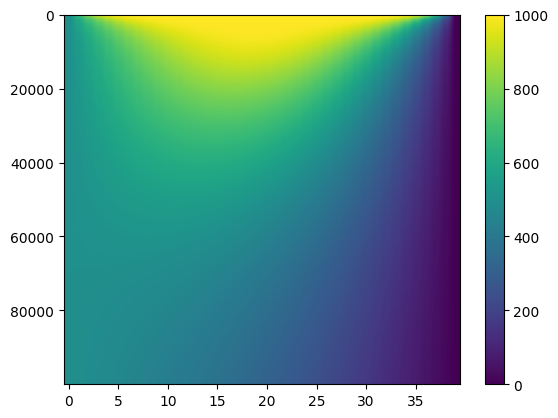

In [42]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(Pexplicita,aspect='auto')
plt.colorbar()

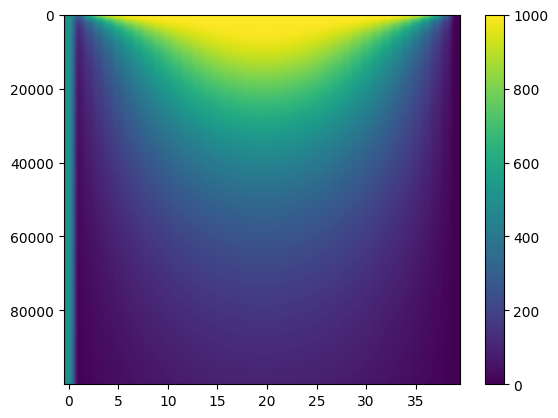

In [43]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(Pimplicita,aspect='auto')
plt.colorbar()